# Assignment 2 (Part b) : SVMs
# Qeustion 1 : Binary Classification 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from time import time
import math
from cvxopt import solvers, matrix

from scipy.spatial.distance import cdist

from sklearn.svm import SVC
from sklearn.metrics import accuracy_score

from itertools import combinations 

from joblib import Parallel, delayed
import multiprocessing

In [2]:
def getData(train, test, val, class1=2, class2=3):
    train = train[np.logical_or(train[:,-1]==class1, train[:,-1]==class2)] 
    val = val[np.logical_or(val[:,-1]==class1, val[:,-1]==class2)] 
    test = test[np.logical_or(test[:,-1]==class1, test[:,-1]==class2)] 

    X_train = train[:,:-1]/255
    Y_train = train[:,-1]
    Y_train = np.array([-1 if i==class1 else 1 for i in Y_train]).reshape((Y_train.shape[0],1))

    X_val = val[:,:-1]/255
    Y_val = val[:,-1]
    Y_val = np.array([-1 if i==class1 else 1 for i in Y_val]).reshape((Y_val.shape[0],1))

    X_test = test[:,:-1]/255
    Y_test = test[:,-1]
    Y_test = np.array([-1 if i==class1 else 1 for i in Y_test]).reshape((Y_test.shape[0],1))
    
    return (X_train, Y_train, X_val, Y_val, X_test, Y_test)

train = pd.read_csv('./data/train.csv', header=None).to_numpy()
val = pd.read_csv('./data/val.csv', header=None).to_numpy()
test = pd.read_csv('./data/test.csv', header=None).to_numpy()

(X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=6, class2=7)

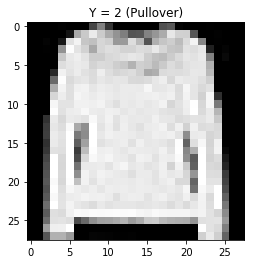

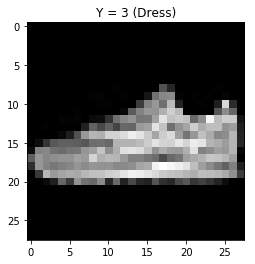

In [3]:
plt.imshow(X_train[np.where(Y_train.ravel() == -1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 2 (Pullover)')
plt.show()
plt.imshow(X_train[np.where(Y_train.ravel() == 1)][0].reshape((28,28)), cmap='gray')
plt.title('Y = 3 (Dress)')
plt.show()

## Part (a) : Implementing Linear SVM

In [4]:
class SVM:
    '''
    This class provides implementation of SVM.
    
    **************
    Parameters:
    C : Regularization parameter (Defalts 1.0)
    threshold : Threshold for alphas i.e. alpha values below this will be treated as 0 (Defalts 1e-5)
    kernel : Type of kernel you want to use ('linear' or 'rbf')
    gamma : Hyperparameter for rbf kernel
    showTime : Boolean to show time taken to fit
    **************
    '''
    
    def __init__(self, C=1, threshold=1e-5, kernel='linear', gamma=0.05, showTime=True):
        self.C = C
        self.threshold = threshold
        self.kernel = kernel
        self.gamma = gamma
        self.showTime = showTime
    
    def _getRBFKernelMat(self, X, gamma = 0.05):
        return np.exp(-gamma*(cdist(X,X)**2))
    
    def fit(self, X_train, Y_train):
        t0 = time()
        
        if self.kernel=='linear':
            self.P = Y_train.dot(Y_train.T) * (X_train.dot(X_train.T))
        elif self.kernel=='rbf':
            self.K = self._getRBFKernelMat(X_train, self.gamma)
            self.P = Y_train.dot(Y_train.T) * (self.K)
        self.P=matrix(self.P,tc='d')

        self.q = -np.ones(X_train.shape[0])
        self.q=matrix(self.q,tc='d')

        self.G = np.vstack((-np.identity(X_train.shape[0]), np.identity(X_train.shape[0])))
        self.G=matrix(self.G,tc='d')

        self.h = np.hstack((np.zeros(X_train.shape[0]), np.zeros(X_train.shape[0])+self.C))
        self.h=matrix(self.h,tc='d')

        self.A = Y_train.T
        self.A = matrix(self.A,tc='d')
        self.b=matrix([0],tc='d')

        solvers.options['show_progress'] = False
        self.opt = solvers.qp(self.P, self.q, self.G, self.h, self.A, self.b)

        self.alphas = np.array(self.opt['x']).ravel()

        self.alphas[self.alphas<self.threshold] = 0

        self.nSV = np.where(self.alphas > 0)[0].shape[0]
        self.SV_indices = np.where(self.alphas > 0)[0]
        self.SV_y = Y_train[self.SV_indices].ravel()
        self.SV = X_train[self.SV_indices]
        
        if self.kernel == 'linear':
            self.w = (X_train[self.SV_indices]).T.dot((Y_train[self.SV_indices].ravel())*self.alphas[self.SV_indices])
            X_pos = X_train[np.where(Y_train.ravel() == 1)]
            X_neg = X_train[np.where(Y_train.ravel() == -1)]
            self.b = -(1/2)*(min(X_pos.dot(self.w)) + max(X_neg.dot(self.w)))

        elif self.kernel == 'rbf':
            X_pos_indices = np.where(Y_train.ravel() == 1)[0]
            X_neg_indices = np.where(Y_train.ravel() == -1)[0]
            alphaiXyi = self.alphas*Y_train.ravel()
            Min = math.inf
            for i in X_pos_indices:            
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * self.K[i,j])
                if(Sum<Min):
                    Min=Sum
            Max = -math.inf
            for i in X_neg_indices:
                Sum = 0
                for j in self.SV_indices:
                    Sum = Sum + (alphaiXyi[j] * self.K[i,j])
                if(Sum>Max):
                    Max=Sum
            self.b = -(1/2)*(Max+Min)
        if self.showTime:
            print("Training completed in %.2f seconds"%((time()-t0)))
        

    def predict(self,X):
        pred = list()
        if self.kernel=='linear':
            for pt in X:
                if (self.SV).T.dot(self.SV_y*self.alphas[self.SV_indices]).dot(pt) + self.b > 0:
                    pred.append(1)
                else:
                    pred.append(-1)
        elif self.kernel=='rbf':
            for pt in tqdm(X):
                wTxPlusb = np.sum((self.alphas[self.SV_indices]*self.SV_y).reshape(self.nSV,1) \
                                  * np.exp(-self.gamma * (cdist(self.SV,np.array([pt]), 'minkowski', p=2)**2))) + self.b
                if wTxPlusb>0:
                    pred.append(1)
                else:
                    pred.append(-1)
        return np.array(pred)

class metrics:
    
    def accuracy_score(y_true, y_pred):
        true = sum(y_true.ravel() == y_pred.ravel())
        return true*100/len(y_true)

In [5]:
linearSVM = SVM(C=1.0, threshold=1e-5, kernel='linear')

linearSVM.fit(X_train, Y_train)

Training completed in 63.36 seconds


In [6]:
print('Number of support vectors :',linearSVM.nSV)

Number of support vectors : 370


In [7]:
pred_train = linearSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = linearSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = linearSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset : ', accuracy_train)
print('Accuracy on Validation Dataset : ', accuracy_val)
print('Accuracy on Test Dataset : ', accuracy_test)

Accuracy on Train Dataset :  92.77777777777777
Accuracy on Validation Dataset :  89.6
Accuracy on Test Dataset :  91.3


## Part B : Applying SVM with Gaussian Kernel

In [5]:
rbfSVM = SVM(C=1.0, threshold=1e-5, kernel='rbf', gamma=0.05)

rbfSVM.fit(X_train, Y_train)

Training completed in 66.15 seconds


In [7]:
rbfSVM.b

-0.6041689242992255

In [6]:
print('Number of support vectors in RBF-SVM:',rbfSVM.nSV)

Number of support vectors in RBF-SVM: 678


In [10]:
pred_train = rbfSVM.predict(X_train)
accuracy_train = metrics.accuracy_score(Y_train, pred_train)

pred_test = rbfSVM.predict(X_test)
accuracy_test = metrics.accuracy_score(Y_test, pred_test)

pred_val = rbfSVM.predict(X_val)
accuracy_val = metrics.accuracy_score(Y_val, pred_val)

print('Accuracy on Train Dataset :', accuracy_train)
print('Accuracy on Validation Dataset :', accuracy_val)
print('Accuracy on Test Dataset :', accuracy_test)

100%|██████████| 500/500 [00:03<00:00, 161.17it/s]

Accuracy on Train Dataset : 99.4
Accuracy on Validation Dataset : 97.2
Accuracy on Test Dataset : 96.1


In [66]:
P = Y_train.dot(Y_train.T) * (getRBFKernelMat(X_train))
P=matrix(P,tc='d')
print('Shape of P :',P.size)

q = -np.ones(X_train.shape[0])
q=matrix(q,tc='d')
print('Shape of q :',q.size)

G = np.vstack((-np.identity(X_train.shape[0]), np.identity(X_train.shape[0])))
G=matrix(G,tc='d')
print('Shape of G :',G.size)
C=1.0
h = np.hstack((np.zeros(X_train.shape[0]), np.zeros(X_train.shape[0])+C))
h=matrix(h,tc='d')
print('Shape of h :',h.size)

A = Y_train.T
A = matrix(A,tc='d')
b=matrix([0],tc='d')
print('Shape of A :',A.size)

opt = solvers.qp(P, q, G, h, A, b)

alphas = np.array(opt['x']).ravel()

# alphas[alphas<threshold] = 0

# nSV = np.where(alphas > 1e-5)[0].shape[0]
# SV_indices = np.where(alphas > 1e-5)[0]
# SV_y = Y_train[SV_indices].ravel()
# SV = X_train[SV_indices]

# w = (X_train[SV_indices]).T.dot((Y_train[SV_indices].ravel())*alphas[SV_indices])

# X_pos = X_train[np.where(Y_train.ravel() == 1)]
# X_neg = X_train[np.where(Y_train.ravel() == -1)]
# b = -(1/2)*(min(X_pos.dot(w)) + max(X_neg.dot(w)))

100%|██████████| 4500/4500 [00:35<00:00, 127.09it/s]


Shape of P : (4500, 4500)
Shape of q : (4500, 1)
Shape of G : (9000, 4500)
Shape of h : (9000, 1)
Shape of A : (1, 4500)
     pcost       dcost       gap    pres   dres
 0: -1.5598e+02 -6.9927e+03  3e+04  2e+00  1e-15
 1: -8.8657e+01 -3.4857e+03  6e+03  2e-01  2e-15
 2: -5.9446e+01 -7.3609e+02  8e+02  2e-02  2e-15
 3: -1.0523e+02 -2.6151e+02  2e+02  4e-03  2e-15
 4: -1.2171e+02 -1.8069e+02  6e+01  1e-03  1e-15
 5: -1.2850e+02 -1.5673e+02  3e+01  1e-14  1e-15
 6: -1.3314e+02 -1.4204e+02  9e+00  8e-16  1e-15
 7: -1.3446e+02 -1.3849e+02  4e+00  1e-14  1e-15
 8: -1.3538e+02 -1.3651e+02  1e+00  2e-14  1e-15
 9: -1.3573e+02 -1.3581e+02  8e-02  3e-14  1e-15
10: -1.3576e+02 -1.3576e+02  2e-03  4e-14  1e-15
11: -1.3576e+02 -1.3576e+02  6e-05  4e-15  1e-15
Optimal solution found.


## Part c : Comparing our implementation with scikit-learn's implementation

In [5]:
svm = SVC(C=1, kernel='linear')
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('Linear SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
# print('b : %s'%(svm.intercept_))
print('nSV : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

Linear SVM trined in 0.24 sec
nSV : [33 24]
Total Support vectors : 57
Accuracy on train data 100.00 %
Accuracy on validation data 99.80 %
Accuracy on test data 100.00 %


In [4]:
svm = SVC(C=1, kernel='rbf', gamma=0.05)
t0 = time()
svm.fit(X_train, Y_train.ravel())
print('RBF SVM trined in %.2f sec'%(time()-t0))

# print('W : %s'%(svm.coef_))
# print('b : %s'%(svm.intercept_))
print('Support vectors : %s'%(svm.n_support_))
print('Total Support vectors : %s'%(svm.n_support_.sum()))

pred_train = svm.predict(X_train)
pred_val = svm.predict(X_val)
pred_test = svm.predict(X_test)

print('Accuracy on train data %.2f %c'%(accuracy_score(Y_train, pred_train)*100,'%'))
print('Accuracy on validation data %.2f %c'%(accuracy_score(Y_val, pred_val)*100,'%'))
print('Accuracy on test data %.2f %c'%(accuracy_score(Y_test, pred_test)*100,'%'))

RBF SVM trined in 3.13 sec
Support vectors : [409 417]
Total Support vectors : 826
Accuracy on train data 100.00 %
Accuracy on validation data 100.00 %
Accuracy on test data 99.80 %


$$\begin{eqnarray} \min_{w}\frac{1}{2}||w||^{2} \nonumber \\\ \textrm{s.t.}\quad y_{i}(w^{T}x_{i} + b) \ge 1 \quad \forall i \end{eqnarray}$$

$$\begin{eqnarray} \min_{\alpha}\frac{1}{2} \alpha^{T}K\alpha - 1^{T}\alpha \nonumber \\\ \textrm{s.t.}\quad \alpha_{i} \ge 0 \quad \forall i \\\ \textrm{and}\quad y^{T}\alpha = 0 \end{eqnarray}$$

$$\begin{eqnarray} \min_{x}\frac{1}{2} x^{T}Px - q^{T}x \nonumber \\\ \textrm{s.t.}\quad Gx \preceq h \\\ \textrm{and}\quad Ax = b \end{eqnarray}$$

# Question 2 : Multi-class Classification

In [5]:
comb = list(combinations(range(10), 2))

In [ ]:
models = list()

def getModel(c1,c2):
    (X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=c1, class2=c2)    
    model = SVM(C=1, threshold=1e-5, kernel='rbf', gamma=0.05, )
    model.fit(X_train, Y_train)
    return model

results = Parallel(n_jobs=4)(delayed(getModel)(c1, c2) for (c1,c2) in tqdm(comb, desc='OneVsOne Models generation'))

# for (c1,c2) in tqdm(comb):
#     models.append(getModel(c1,c2))

OneVsOne Models generation:  27%|██▋       | 12/45 [10:15<27:29, 49.99s/it]

In [5]:
X_train_whole = train[:,:-1]
Y_train_whole = train[:,-1]

In [6]:
X_train_whole.shape

(22500, 784)

In [ ]:
svc_multi = SVC(C=1.0, kernel='rbf', gamma=0.05)
svc_multi.fit(X_train_whole, Y_train_whole)

In [27]:
sklearnModels = list()

def getSklearnModel(c1, c2):
    (X_train, Y_train, X_val, Y_val, X_test, Y_test) = getData(train, test, val, class1=c1, class2=c2)    
    model = SVC(C=1, kernel='rbf', gamma=0.05, probability=True)
    model.fit(X_train, Y_train.ravel())
    return model

results = Parallel(n_jobs=-2)(delayed(getSklearnModel)(c1, c2) for (c1,c2) in tqdm(combinations, desc='OneVsOne Models generation'))
# for (c1,c2) in tqdm(combinations):
#     sklearnModels.append(getSklearnModel(c1,c2))

OneVsOne Models generation: 100%|██████████| 45/45 [02:33<00:00,  3.42s/it]
